In [1]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, Reshape, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, BatchNormalization, Dense, Dropout, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [ ]:
#input data

train_datagen_init = ImageDataGenerator(rescale=1./255)

#we do not apply transformation to test data
test_datagen = ImageDataGenerator(rescale=1./255)

#train generator will generate data on the fly
train_generator_init = train_datagen_init.flow_from_directory('data/birds/train',
                                                   target_size=(150,150),
                                                   batch_size=32,
                                                   class_mode='categorical',color_mode='rgb')


test_generator = test_datagen.flow_from_directory(
    'data/birds/test',
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42)

In [ ]:
##model

model = Sequential()
model.add(Dense(300, input_shape=(150,150,3), activation='relu')) 
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150, 150, 300)     1200      
_________________________________________________________________
dropout (Dropout)            (None, 150, 150, 300)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      86432     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0

In [ ]:
#training model
history=model.fit(train_generator_init,steps_per_epoch=3, epochs=2) 

Epoch 1/2
3/3 [==============================] - 21s 7s/step - loss: 5.6119 - accuracy: 0.1042
Epoch 2/2
3/3 [==============================] - 16s 5s/step - loss: 2.4229 - accuracy: 0.1250


In [ ]:
#test
filenames = test_generator.filenames
nb_samples = len(filenames)

score = model.evaluate(test_generator,steps = nb_samples)
err = 100*(1-np.array(score))
print('Test error:',err[1],' Test loss:', err[0],'\n')

#accuracy: 0.1000

100/100 [==============================] - 40s 401ms/step - loss: 2.3384 - accuracy: 0.1000
Test error: 89.99999985098839  Test loss: -133.84137153625488 



In [ ]:
#Using data augmentation

train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.3,zoom_range=0.3,horizontal_flip=True,
                                   width_shift_range=0.3, height_shift_range=0.3)
train_generator = train_datagen.flow_from_directory('data/birds/train',
                                                   target_size=(150,150),
                                                   batch_size=32,
                                                   class_mode='categorical',color_mode='rgb')

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

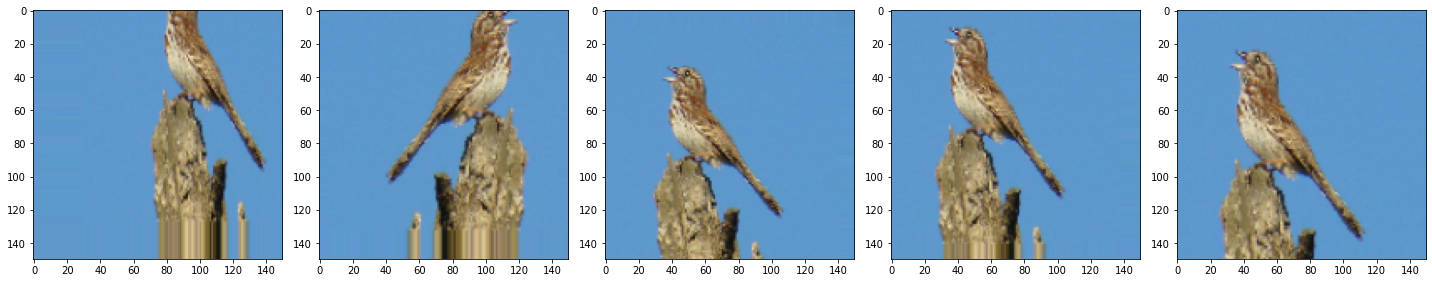

In [ ]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
#new model with augumentation
history=model.fit(train_generator,steps_per_epoch=5,
        epochs=2,) 

Epoch 1/2
5/5 [==============================] - 17s 3s/step - loss: 2.3552 - accuracy: 0.1250
Epoch 2/2
5/5 [==============================] - 15s 3s/step - loss: 2.3599 - accuracy: 0.0875


In [ ]:
score = model.evaluate(test_generator,steps = nb_samples)
err = 100*(1-np.array(score))
print('Test error:',err[1],' Test loss:', err[0],'\n')

#accuracy: 0.0800 need more epochs

100/100 [==============================] - 1s 7ms/step - loss: 2.3022 - accuracy: 0.0800
Test error: 92.00000017881393  Test loss: -130.21728992462158 



In [ ]:
#Using a pretrained model

#DenseNet121 architecture
from keras.applications import DenseNet121

base_model=DenseNet121(weights='imagenet',include_top=False)

#additional output layers
additional_layer=base_model.output
additional_layer2=GlobalAveragePooling2D()(additional_layer)
additional_layer3=Dense(100,activation='relu')(additional_layer2)
predictions=Dense(10,activation='softmax')(additional_layer3)
model=Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
        layer.trainable = False

base_model.trainable = False
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

In [ ]:
history=model.fit(train_generator,steps_per_epoch=5,
        epochs=1,)

5/5 [==============================] - 9s 2s/step - loss: 3.5004 - accuracy: 0.1069


In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

score = model.evaluate(test_generator,steps = nb_samples)
err = 100*(1-np.array(score))
print('Test error:',err[1],' Test loss:', err[0],'\n')

#accuracy: 0.2700 improved accuracy with pretrained model

100/100 [==============================] - 1s 14ms/step - loss: 2.8807 - accuracy: 0.2700
Test error: 72.9999989271164  Test loss: -188.07425498962402 



In [ ]:
callback_earlystopping=EarlyStopping(monitor='loss', patience=2)
model.fit(train_generator,steps_per_epoch=10,
        epochs=1,callbacks=[callback_earlystopping])

In [ ]:
score = model.evaluate(test_generator,steps = nb_samples)
err = 100*(1-np.array(score))
print('Test error:',err[1],' Test loss:', err[0],'\n')

In [7]:
#pretrained model with image augumentation

train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.4,zoom_range=0.4,horizontal_flip=True,
                                   width_shift_range=0.4, height_shift_range=0.4)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data/birds/train',
                                                   target_size=(150,150),
                                                   batch_size=32,
                                                   class_mode='categorical',color_mode='rgb')


test_generator = test_datagen.flow_from_directory('data/birds/test',target_size=(150, 150),color_mode="rgb",batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42)


Found 479 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [8]:
from keras.applications import DenseNet121


base_model=DenseNet121(weights='imagenet',include_top=False)
additional_layer=base_model.output
additional_layer2=GlobalAveragePooling2D()(additional_layer)
additional_layer3=Dense(1024,activation='relu')(additional_layer2)
additional_layer3 = BatchNormalization()(additional_layer3)
additional_layer3 = Dropout(0.3)(additional_layer3)
additional_layer4=Dense(512,activation='relu')(additional_layer3)
additional_layer4 = BatchNormalization()(additional_layer4)
additional_layer4 = Dropout(0.3)(additional_layer4)
additional_layer5=Dense(256,activation='relu')(additional_layer4)
additional_layer5 = BatchNormalization()(additional_layer5)
additional_layer5 = Dropout(0.3)(additional_layer5)
additional_layer6=Dense(128,activation='relu')(additional_layer5)
additional_layer6 = BatchNormalization()(additional_layer6)
additional_layer6 = Dropout(0.2)(additional_layer6)
predictions=Dense(10,activation='softmax')(additional_layer6)

model=Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
        layer.trainable = False
base_model.trainable = False
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

29089792/29084464 [==============================] - 0s 0us/step


In [9]:
history=model.fit(train_generator,steps_per_epoch=5,
        epochs=100,verbose=0)

In [10]:
score = model.evaluate(test_generator)
accuracy = 100*(np.array(score))
print('Test accuracy:',accuracy[1])

#Test accuracy: 93.00000071525574 which is much better than previous models

100/100 [==============================] - 25s 246ms/step - loss: 0.2285 - accuracy: 0.9300
Test accuracy: 93.00000071525574


In [11]:
#Using VGG16 model

from keras.applications.vgg16 import VGG16

base_model=VGG16(input_shape = (150,150, 3), include_top = False, weights = 'imagenet')

additional_layer=base_model.output
additional_layer2=GlobalAveragePooling2D()(additional_layer)
additional_layer3=Dense(1024,activation='relu')(additional_layer2)
additional_layer3 = BatchNormalization()(additional_layer3)
additional_layer3 = Dropout(0.3)(additional_layer3)
additional_layer4=Dense(512,activation='relu')(additional_layer3)
additional_layer4 = BatchNormalization()(additional_layer4)
additional_layer4 = Dropout(0.3)(additional_layer4)
additional_layer5=Dense(256,activation='relu')(additional_layer4)
additional_layer5 = BatchNormalization()(additional_layer5)
additional_layer5 = Dropout(0.3)(additional_layer5)
additional_layer6=Dense(128,activation='relu')(additional_layer5)
additional_layer6 = BatchNormalization()(additional_layer6)
additional_layer6 = Dropout(0.2)(additional_layer6)
predictions=Dense(10,activation='softmax')(additional_layer6)

model=Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
        layer.trainable = False
base_model.trainable = False
    
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history=model.fit(train_generator,steps_per_epoch=5,
        epochs=100,verbose=0)

score = model.evaluate(test_generator)
accuracy = 100*(np.array(score))
print('Test accuracy:',accuracy[1])

#Test accuracy: 69.9999988079071
#VGG16 gives poor accuracy scores using the same architecture as densenet121

100/100 [==============================] - 1s 9ms/step - loss: 1.0573 - accuracy: 0.7000
Test accuracy: 69.9999988079071
